In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

In [4]:
import fipy as fp

In [5]:
from fipy import numerix as nmx

In [153]:
Calpha = fp.Variable(0.05, name=r"$C_\alpha$")
Cbeta = fp.Variable(0.95, name=r"$C_\beta$")
Cm = (Calpha + Cbeta) / 2.
Cm.name = "$C_m$"
A = fp.Variable(2.0, name="A")
B = A / (Calpha - Cm)**2
B.name = "B"
gamma = 2. / (Cbeta - Calpha)**2
gamma.name = r"$\gamma$"
beta = fp.Variable(1.0, name=r"$\beta$")
Dalpha = gamma / beta**2
Dalpha.name = r"$D_\alpha$"
Dbeta = gamma / beta**2
Dbeta.name = r"$D_\beta$"
epsilonij = fp.Variable(3.0, name=r"$\epsilon_{ij}$")
kappai = fp.Variable(2.0, name=r"$\kappa_i$")
kappaC = fp.Variable(2.0, name=r"$\kappa_C$")
D = fp.Variable(1.0, name="D")
Li = fp.Variable(1.0, name="$L_i$")

In [281]:
N = 100
mesh = fp.Grid2D(nx=N, ny=N, Lx=8., Ly=8.) + [[-4.], [-4.]]

In [154]:
N = 100
mesh = fp.Grid1D(nx=N, Lx=1.)

In [282]:
C = fp.CellVariable(mesh=mesh, name="C", hasOld=True)

In [283]:
eta = [fp.CellVariable(mesh=mesh, name=r"$\eta_{i}$".format(i=i+1), hasOld=True) for i in range(1)]

In [284]:
f1 = -(A/2)*(C - Cm)**2 + (B/4)*(C - Cm)**4 + (Dalpha/4)*(C - Calpha)**4 + (Dbeta/4)*(C - Cbeta)**4
f1.name = "$f_1$"

f2 = []
for i, etai in enumerate(eta):
    f2i = -(gamma/2)*(C - Calpha)**2 * etai**2 + (beta/4)*etai**4
    f2i.name = "$f_{{2{i}}}$".format(i=i+1)
    f2.append(f2i)

f3 = []
for i, etai in enumerate(eta):
    f3i = []
    for j, etaj in enumerate(eta):
        if etaj is not etai:
            f3ij = (epsilonij/2) * etai**2 * etaj**2 
            f3ij.name = "$f_{{3{i}{j}}}$".format(i=i+1, j=j+1)
        else:
            f3ij = None
        f3i.append(f3ij)
    f3.append(f3i)
    
f0 = f1
for f2i in f2:
    f0 += f2i
for f3i in f3:
    for f3ij in f3i:
        if f3ij is not None:
            f0 += f3ij
f0.name = "$f_0$"

In [285]:
f = f0 + (kappaC/2.)*(C.grad.mag)**2
for etai in eta:
    f += (kappai/2.)*(etai.grad.mag)**2
f.name = "f"

In [286]:
beta.value = 1.

In [287]:
print Dalpha

2.46913580247


In [288]:
C.value = mesh.x

In [289]:
eta[0].value = mesh.y

In [290]:
eta[1].value = 0 + 1. * mesh.y

IndexError: list index out of range

In [217]:
f0.__class__.__bases__[0]._getRepresentation(f0)

'$f_1$ + $f_{21}$'

In [224]:
f0._getCstring()

'((((((pow((var0000000[i] - var0000001), var000001)) * -((var0000100 / var0000101))) + ((pow((var0001000[i] - var0001001), var000101)) * ((var0001100 / (pow((var000110100 - var000110101), var00011011))) / var000111))) + ((pow((var001000[i] - var001001), var00101)) * ((var001100 / (pow(var0011010, var0011011))) / var00111))) + ((pow((var01000[i] - var01001), var0101)) * ((var01100 / (pow(var011010, var011011))) / var0111))) + ((((pow((var100000[i] - var100001), var10001)) * -((var100100 / var100101))) * (pow(var1010[i], var1011))) + ((pow(var1100[i], var1101)) * (var1110 / var1111))))'

In [225]:
f0.var[0].__class__.__bases__[0]._getRepresentation(f0.var[0])

'((((pow((C - $C_m$), 2)) * -((A / 2))) + ((pow((C - $C_m$), 4)) * (B / 4))) + ((pow((C - $C_\\alpha$), 4)) * ($D_\\alpha$ / 4))) + ((pow((C - $C_\\beta$), 4)) * ($D_\\beta$ / 4))'

In [216]:
f0.var[1].__class__.__bases__[0]._getRepresentation(f0.var[1])

'(((pow((C - $C_\\alpha$), 2)) * -(($\\gamma$ / 2))) * (pow($\\eta_1$, 2))) + ((pow($\\eta_1$, 4)) * ($\\beta$ / 4))'

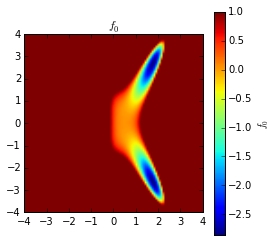

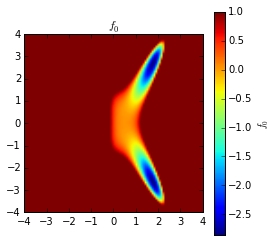

In [302]:
fp.MatplotlibViewer(vars=f0, datamin=None, datamax=1.).plot()

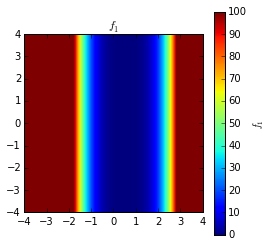

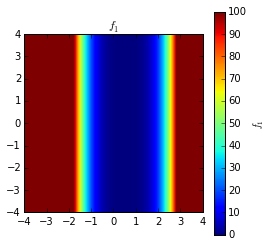

In [298]:
fp.MatplotlibViewer(vars=f1, datamax=100).plot()

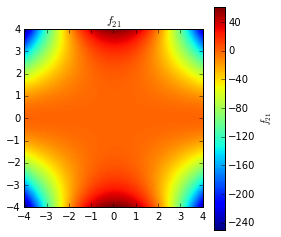

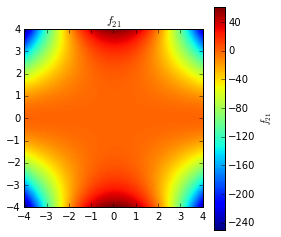

In [299]:
fp.MatplotlibViewer(vars=f2[0]).plot()

In [300]:
fp.MatplotlibViewer(vars=f2[1]).plot()

IndexError: list index out of range

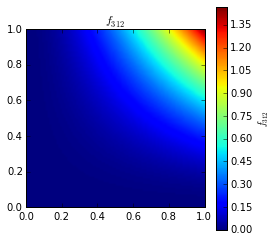

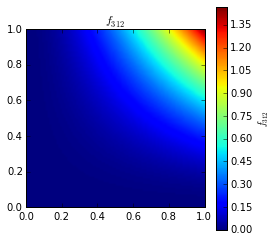

In [118]:
fp.MatplotlibViewer(vars=f3[0][1]).plot()

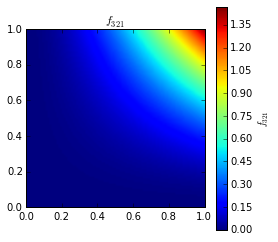

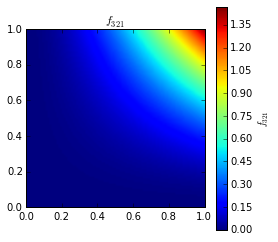

In [119]:
fp.MatplotlibViewer(vars=f3[1][0]).plot()

# 1d

In [173]:
eta[0].value = 0.
eta[0].setValue(1., where=mesh.x < 25)

In [106]:
eta[1].value = 0.
eta[1].setValue(1., where=mesh.x > 120)

In [174]:
C.value = 0.5

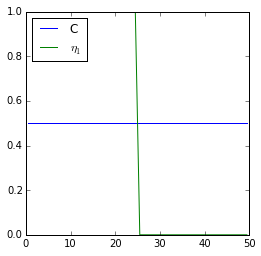

In [167]:
viewer = fp.MatplotlibViewer(vars=[C] + eta)

In [175]:
dt = 1.
elapsed = 0.
saved = elapsed
duration = 10000.
step = 0

In [33]:
fp.tools.dump.write(mesh, filename="mesh.dmp")

In [34]:
fp.TSVViewer(vars=[C] + eta).plot(filename="{step}.gz".format(step=0))

In [169]:
with open("stats.txt", 'w') as stats:
    stats.write("\t".join(["step", "t", "dt", "Cmin", "Cmax", "f"]) + "\n")

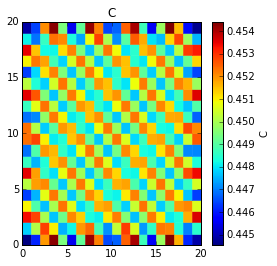

In [39]:
viewerC = fp.MatplotlibViewer(vars=C)

In [176]:
while elapsed < duration:
    C.updateOld()
    for etai in eta:
        etai.updateOld()
    for sweep in range(6):
#        res = eq.sweep(dt=dt)
        res = [eqC.sweep(C, dt=dt)] #, solver=fp.LinearLUSolver())
        # res = [eq_etai.sweep(etai, dt=dt) for (eq_etai, etai) in zip(eq_eta, eta)]
    print dt
    if max(res) < 0.1:
        step += 1
        elapsed += dt
        # dt *= 1.1
        viewer.plot()
        if elapsed - saved > 1:
            fp.TSVViewer(vars=[C] + eta).plot(filename="{step}.gz".format(step=step))
            # viewer.plot()
            saved = elapsed
        with open("stats.txt", 'a') as stats:
            stats.write("\t".join([str(it) for it in [step, elapsed, dt, min(C), max(C), 
                                                      f.cellVolumeAverage * mesh.cellVolumes.sum()]]) + "\n")
    else:
        dt *= 0.8
        C.value = C.old.value

KeyboardInterrupt: 

In [177]:
print min(C), max(C), C.cellVolumeAverage

0.00563854161095 0.997223488975 0.499999998989
